# Importing Dependencies

In [3]:
# Data Handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re

# ML/Evals
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
%pip install xgboost
import xgboost as xgb

# Tuning
from scipy.stats import randint
# from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Read in Data
data = pd.read_csv('data/challenge_dataset.csv')
data.head(3)

,customer_id,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,integrations_count,...,account_size,third_party_integration_flag,register_sale_ord,account_created_time,first_activated_time,min_bill_date,max_bill_date,sticky_bill_date,address,marketing_campaign_response
0,1168239,7,2,0,0,0,0,0,0,108.0,...,NaN,1,1.0,2016-04-04 19:17:49,2016-06-12 23:08:01,2016-06-05,2021-03-18,2016-07-12,"906 Cindy Trafficway Suite 948, AZ, US",1
1,6076186,10,4,0,0,0,2,0,0,84.0,...,medium,1,NaN,2020-11-16 14:22:58,2020-11-10 14:55:27,2020-11-24,2021-03-06,2020-10-30,"9093 Taylor Greens Apt. 852, FL, US",1
2,3254220,0,0,0,0,0,0,0,0,90.0,...,small,2,NaN,2018-04-30 15:01:46,NaN,2018-04-28,2018-11-08,2018-05-21,"5161 Wilson Summit, SC, US",0


## (Not Complete) Census API Call

Add features using publicly available Census data API. 

In [10]:
def extract_state(address):
    if pd.isna(address):  # Check if address is NaN
        return None  # Return None for NaN values
    state_pattern = r',\s*([A-Z]{2}),\s*'  # State pattern regex
    match = re.search(state_pattern, str(address))  # Search for the pattern
    if match:
        return match.group(1)  # Return the state code if found
    else:
        return None  # Return None if state code is not found

# Apply the extract_state function to the 'address' column
test = data['address'].apply(extract_state)

In [11]:
test.unique()

array(['AZ', 'FL', 'SC', 'NM', 'CA', 'VA', 'MN', 'TX', 'ON', 'NY', 'WA',
       'MD', 'NJ', 'GA', 'OH', 'WV', 'CT', 'DE', 'MI', 'QC', 'LA', 'NV',
       'IL', 'PA', 'OR', 'NE', 'AL', 'AB', 'AR', 'UT', 'BC', 'CO', 'NC',
       'IN', 'MO', 'WI', 'IA', 'NS', 'PR', 'OK', 'MB', 'MT', 'KS', 'MA',
       'TN', 'DC', 'RI', 'KY', 'ID', 'ME', 'MS', 'VI', 'SD', 'WY', 'HI',
       'NH', 'ND', 'AK', 'SK', None, 'FM', 'NB', 'VT', 'PE', 'NL'],
      dtype=object)

64 Unique States

## Data Overview

In [21]:
def overview(df, text):
    """
    Gives basic summary stats of data
    """
    print(f'{text}\n')
    print('Number of Rows:', df.shape[0])
    print('Number of Features:', df.shape[1])
    print('\nUnique Features and Types:')
    print(data.dtypes)
    print('\nMissing Values:\n',df.isnull().sum())
    print('\nUnique Values:')
    print(df.nunique())
    print('\nDuplicates:')
    print(df.duplicated().value_counts())

overview(data, 'Overview of Dataset')

Overview of Dataset

Number of Rows: 20004
Number of Features: 29

Unique Features and Types:
customer_id                       int64
num_services                      int64
num_services_active               int64
num_services_inactive             int64
cc_service_count                  int64
db_service_count                  int64
nlp_service_count                 int64
cc_pro_service_count              int64
ml_service_count                  int64
integrations_count              float64
third_party_integrations        float64
num_businesses                  float64
tier_level                       object
customer_type                    object
enterprise_account                 bool
enterprise_account_legacy          bool
is_activated                       bool
has_cloud_storage                  bool
has_cloud_storage_only             bool
account_size                     object
third_party_integration_flag      int64
register_sale_ord               float64
account_created_time      

#### Observations:

Not too many duplicates. 20000 unique customer_ids, validated. A few variables have >50% missing values. How was this data collected? Survey, online form, interviews?

## Data Cleaning

### Remove Duplicates

In [13]:
# 4 found in Data Overview 
data = data.drop_duplicates()
data.shape

(20000, 29)

### Missing Values

In [14]:
# All null variables
null = data.isnull().sum()
null[null > 0]

num_businesses          14558
customer_type               3
account_size            13074
register_sale_ord       13901
first_activated_time     8284
sticky_bill_date          950
address                    25
dtype: int64

Num_businesses and Account_size might be potential features that explain the response (campaign engagement) well. However, they both contain > 50% missing values.

### Data Types

In [23]:
# All columns of type 'Object'
type_obj = data.select_dtypes(include = object)
type_obj.head(5)

,tier_level,customer_type,account_size,account_created_time,first_activated_time,min_bill_date,max_bill_date,sticky_bill_date,address
0,PREMIUM_PLUS,Services,NaN,2016-04-04 19:17:49,2016-06-12 23:08:01,2016-06-05,2021-03-18,2016-07-12,"906 Cindy Trafficway Suite 948, AZ, US"
1,LITE,Business_type_1,medium,2020-11-16 14:22:58,2020-11-10 14:55:27,2020-11-24,2021-03-06,2020-10-30,"9093 Taylor Greens Apt. 852, FL, US"
2,PREMIUM_PLUS,Services,small,2018-04-30 15:01:46,NaN,2018-04-28,2018-11-08,2018-05-21,"5161 Wilson Summit, SC, US"
3,PREMIUM,Business_type_1,NaN,2019-06-05 15:54:07,2019-06-08 19:59:39,2019-05-30,2021-02-09,NaN,"8986 Michelle Falls, FL, US"
4,LITE,Business_type_1,large,2018-12-17 05:13:08,2019-01-08 15:39:22,2018-12-16,2021-03-15,2019-02-21,"71039 Burns Prairie, FL, US"


In [24]:
# Type 'Int64'
type_int = data.select_dtypes(include = int)
type_int.head(5)

,customer_id,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,third_party_integration_flag,marketing_campaign_response
0,1168239,7,2,0,0,0,0,0,0,1,1
1,6076186,10,4,0,0,0,2,0,0,1,1
2,3254220,0,0,0,0,0,0,0,0,2,0
3,4446927,5,10,0,0,0,6,0,0,2,1
4,3845495,7,1,0,0,0,0,0,0,1,1


In [25]:
type_int.describe()

,customer_id,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,third_party_integration_flag,marketing_campaign_response
count,2.000400e+04,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000,20004.000000
mean,3.154530e+06,4.981004,4.876375,0.172266,0.641772,0.233303,1.562288,0.588432,0.072136,1.304089,0.559738
std,1.770741e+06,9.441370,11.172097,1.642563,3.454310,2.041735,5.169174,4.760434,0.866679,0.460032,0.496431
min,2.748400e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.657692e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.171618e+06,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,4.654969e+06,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
max,9.800716e+06,504.000000,975.000000,77.000000,243.000000,125.000000,270.000000,560.000000,45.000000,2.000000,1.000000


In [26]:
# Type 'Float64'
type_float = data.select_dtypes(include = float)
type_float.head(5)

,integrations_count,third_party_integrations,num_businesses,register_sale_ord
0,108.0,0.0,NaN,1.0
1,84.0,0.0,16.0,NaN
2,90.0,0.0,NaN,NaN
3,260.0,1.0,NaN,NaN
4,108.0,21.0,NaN,2.0


In [27]:
type_float.isnull().sum()

integrations_count              0
third_party_integrations        0
num_businesses              14562
register_sale_ord           13905
dtype: int64

In [28]:
# Type 'Bool'
type_bool = data.select_dtypes(include = bool)
type_bool.head(5)

,enterprise_account,enterprise_account_legacy,is_activated,has_cloud_storage,has_cloud_storage_only
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,False,False,False
3,False,False,True,False,False
4,False,False,True,False,False


### Date Formatting

In [29]:
# Date Types
dates = ['account_created_time','first_activated_time', 'min_bill_date', 'max_bill_date','sticky_bill_date']
data[dates]

,account_created_time,first_activated_time,min_bill_date,max_bill_date,sticky_bill_date
0,2016-04-04 19:17:49,2016-06-12 23:08:01,2016-06-05,2021-03-18,2016-07-12
1,2020-11-16 14:22:58,2020-11-10 14:55:27,2020-11-24,2021-03-06,2020-10-30
2,2018-04-30 15:01:46,NaN,2018-04-28,2018-11-08,2018-05-21
3,2019-06-05 15:54:07,2019-06-08 19:59:39,2019-05-30,2021-02-09,NaN
4,2018-12-17 05:13:08,2019-01-08 15:39:22,2018-12-16,2021-03-15,2019-02-21
...,...,...,...,...,...
19999,2018-02-09 16:56:13,2018-02-21 00:43:09,2018-02-13,2021-04-08,2018-02-16
20000,2020-09-04 21:36:50,2020-09-12 01:46:44,2020-10-20,2021-03-14,2020-09-22
20001,2019-11-10 07:18:13,2020-06-04 14:29:24,2020-06-10,2021-04-08,2020-07-10
20002,2016-03-06 00:13:21,NaN,2016-05-31,2017-05-01,2016-06-07


Observations and Further Analysis:

- First activation time removal. Not relevant in predicting campaign responses, 8000+ missing values.
- Sticky_bill_date: "STICKY ACCOUNTS": Related to banking and business, describes the 'closeness' for a consumer in retention/sticking to a service. Take the difference between Sticky_bill_date and Account_Creation dates to understand how long a customer might typically stay loyal. 
- Taking the difference in years between the Max_Bill and Min_Bill to analyze if larger differences in subscription durations result in a greater engagement likelihood.

Issues in Above:

- There are NaNs in the dates. 
- Formatting of the dates are not standardized
- For some of the rows, the sticky bill date precedes the account creation date. I will remove rows where for such occurances because a customers account cannot be sticky if not created. Same principle applies for max and min bill_dates.

In [30]:
# Check for Date Nulls
temp = data[['account_created_time','min_bill_date','max_bill_date','sticky_bill_date']]
temp.isnull().sum()

account_created_time      0
min_bill_date             0
max_bill_date             0
sticky_bill_date        950
dtype: int64

Only nulls in the sticky_bill_date

In [31]:
# Drop NAs in Sticky Bills
temp = temp.dropna(subset = ['sticky_bill_date'])

# Transform objects to DateTime type
temp = temp[temp.columns].apply(pd.to_datetime)

Standardize Dates

In [32]:
# Standardize Dates
temp = temp.map(lambda x: x.strftime('%Y-%m-%d'))

In [33]:
# Transform again
temp = temp[temp.columns].apply(pd.to_datetime)
temp.dtypes

account_created_time    datetime64[ns]
min_bill_date           datetime64[ns]
max_bill_date           datetime64[ns]
sticky_bill_date        datetime64[ns]
dtype: object

In [34]:
# Date Differencing and Feature Engineering
temp['sticky_index'] = temp['sticky_bill_date'] - temp['account_created_time']
temp['contract_length'] = temp['max_bill_date'] - temp ['min_bill_date']

For the new variable **sticky_index** I want to understand how long a customer tends to stay "sticky", starting from account creation date. 

My Hypothesis: Longer sticky index = Greater Engagement. Same applies to variable **contract_length**, which takes the difference between a customer's max and min bill date

In [35]:
# View of features
pd.concat([temp['sticky_index'], temp['contract_length']], axis = 1)

,sticky_index,contract_length
0,99 days,1747 days
1,-17 days,102 days
2,21 days,194 days
4,66 days,820 days
5,75 days,502 days
...,...,...
19999,7 days,1150 days
20000,18 days,145 days
20001,243 days,302 days
20002,93 days,335 days


There are some negative values of days, proceed to remove.

In [36]:
# Format data for use
temp['sticky_index'] = temp['sticky_index'].dt.days
temp['contract_length'] = temp['contract_length'].dt.days

In [37]:
temp = pd.concat([temp['sticky_index'], temp['contract_length']], axis = 1)

In [38]:
# Distribution of Negative Values in Dates
(temp > 0).value_counts()

sticky_index  contract_length
True          True               13326
False         True                5049
True          False                490
False         False                189
Name: count, dtype: int64

The table above lists the distributions of values based on the True/False indicator of the sticky index and contract length. We only want to keep the values where both indicators are True, implying no negatives.

In [39]:
# Remove negatives 
newtemp = temp[(temp > 0).all(1)]

In [40]:
# Look at new shape
newtemp.shape

(13326, 2)

Removing negatives removes around ~6-7k rows of data. 

### More Data Dropping

Join the new features to the original dataset. For this, I matched it based on the index

In [41]:
# This is a left join. Data in temp is matched to those of in the main dataset. If temp data does not match in main, NaN occurs
data = data.join(newtemp)

In [42]:
# Check if successful merge -> QC/QA
data.head(3)

,customer_id,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,integrations_count,...,register_sale_ord,account_created_time,first_activated_time,min_bill_date,max_bill_date,sticky_bill_date,address,marketing_campaign_response,sticky_index,contract_length
0,1168239,7,2,0,0,0,0,0,0,108.0,...,1.0,2016-04-04 19:17:49,2016-06-12 23:08:01,2016-06-05,2021-03-18,2016-07-12,"906 Cindy Trafficway Suite 948, AZ, US",1,99.0,1747.0
1,6076186,10,4,0,0,0,2,0,0,84.0,...,NaN,2020-11-16 14:22:58,2020-11-10 14:55:27,2020-11-24,2021-03-06,2020-10-30,"9093 Taylor Greens Apt. 852, FL, US",1,NaN,NaN
2,3254220,0,0,0,0,0,0,0,0,90.0,...,NaN,2018-04-30 15:01:46,NaN,2018-04-28,2018-11-08,2018-05-21,"5161 Wilson Summit, SC, US",0,21.0,194.0


In [43]:
# Should be equal to 13326
data['sticky_index'].isna().value_counts()

sticky_index
False    13326
True      6678
Name: count, dtype: int64

In [44]:
# Dropping columns with many > 50% missing values. (Num_biz, Account_size, Register_sale)
# Dropping customer_id as it is a unique identifier for rows and does not contribute to the outcome
# Dropping cols/rows based on Date section

data = data.drop(columns = ['customer_id','num_businesses',
                            'account_size', 'register_sale_ord',
                           'first_activated_time', 'first_activated_time',
                           'account_created_time', 'min_bill_date', 'max_bill_date',
                           'sticky_bill_date'])

In [45]:
# Dropping rows that are NaN
data.isnull().sum()

num_services                       0
num_services_active                0
num_services_inactive              0
cc_service_count                   0
db_service_count                   0
nlp_service_count                  0
cc_pro_service_count               0
ml_service_count                   0
integrations_count                 0
third_party_integrations           0
tier_level                         0
customer_type                      3
enterprise_account                 0
enterprise_account_legacy          0
is_activated                       0
has_cloud_storage                  0
has_cloud_storage_only             0
third_party_integration_flag       0
address                           25
marketing_campaign_response        0
sticky_index                    6678
contract_length                 6678
dtype: int64

In [46]:
# Drop rows with NA
data = data.dropna(axis = 0)

In [47]:
data.shape

(13308, 22)

Reasons for Dropping:

- The Customer_ID column is purely a unique customer identifier and has no role in predictive modeling
- Num_businesses, Account_size, Regiser_sale_ord have > 50% missing values
- First Activation Time was replaced by Account Creation Time

### Cleaned Data

In [48]:
# How data looks after cleaning
data.head(3)

,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,integrations_count,third_party_integrations,...,enterprise_account,enterprise_account_legacy,is_activated,has_cloud_storage,has_cloud_storage_only,third_party_integration_flag,address,marketing_campaign_response,sticky_index,contract_length
0,7,2,0,0,0,0,0,0,108.0,0.0,...,False,False,True,False,False,1,"906 Cindy Trafficway Suite 948, AZ, US",1,99.0,1747.0
2,0,0,0,0,0,0,0,0,90.0,0.0,...,False,False,False,False,False,2,"5161 Wilson Summit, SC, US",0,21.0,194.0
4,7,1,0,0,0,0,0,0,108.0,21.0,...,False,False,True,False,False,1,"71039 Burns Prairie, FL, US",1,66.0,820.0


In [49]:
data.shape

(13308, 22)

In [50]:
data.columns

Index(['num_services', 'num_services_active', 'num_services_inactive',
       'cc_service_count', 'db_service_count', 'nlp_service_count',
       'cc_pro_service_count', 'ml_service_count', 'integrations_count',
       'third_party_integrations', 'tier_level', 'customer_type',
       'enterprise_account', 'enterprise_account_legacy', 'is_activated',
       'has_cloud_storage', 'has_cloud_storage_only',
       'third_party_integration_flag', 'address',
       'marketing_campaign_response', 'sticky_index', 'contract_length'],
      dtype='object')

## EDA

### Exploring Target 

In [52]:
responses = data['marketing_campaign_response'].value_counts()
responses

marketing_campaign_response
1    7628
0    5680
Name: count, dtype: int64

Not exactly balanced, but *not heavily imbalanced*

In [53]:
# Proportions of Yes (1) and No (0)
prop = responses / sum(responses)
prop

marketing_campaign_response
1    0.573189
0    0.426811
Name: count, dtype: float64

### Bar Plots

In [54]:
# Simple function for Visualization

def bar(feature):
    """
    Visualizes a nice bar plot for categorical features
    """
    sns.set_theme(style = "whitegrid")
    sns.catplot(data = data,
           kind = "count",
           x = feature,
           hue = "marketing_campaign_response")
    plt.xticks(rotation = 90)
    plt.show()

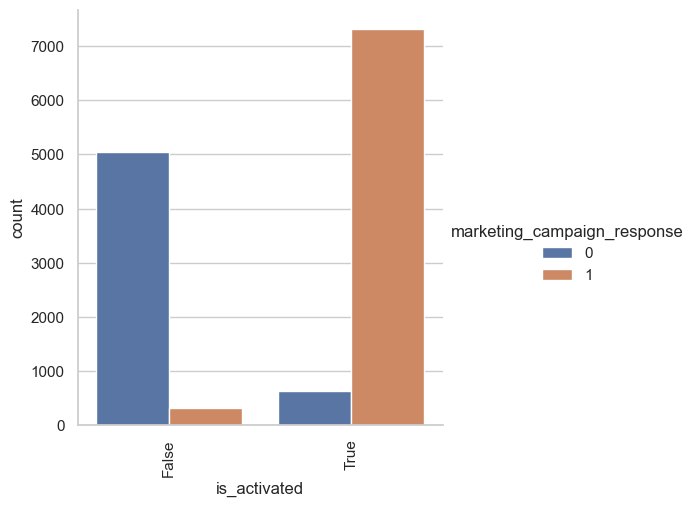

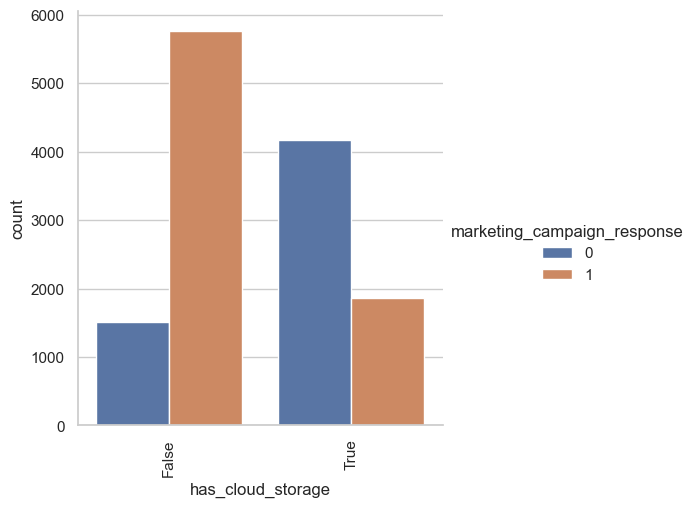

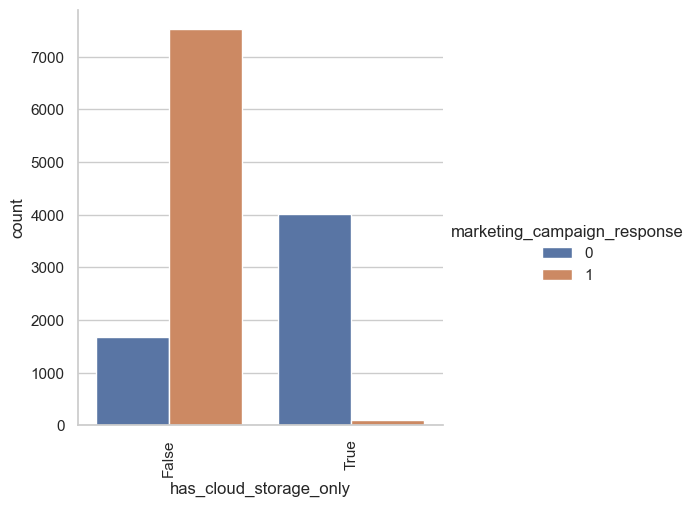

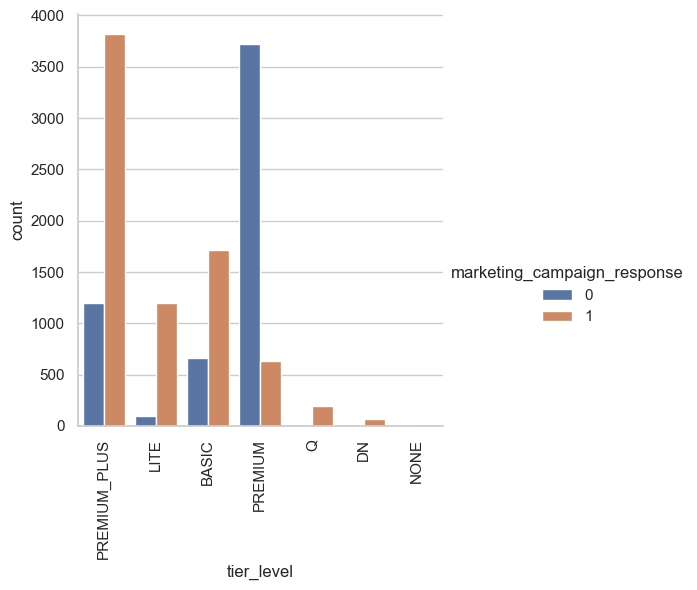

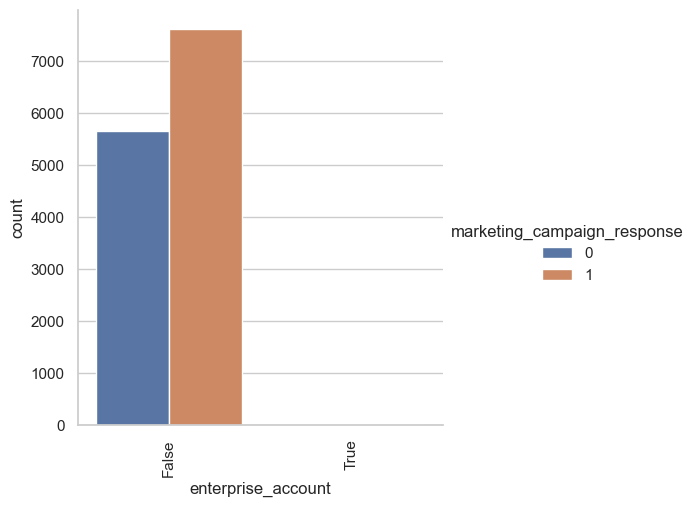

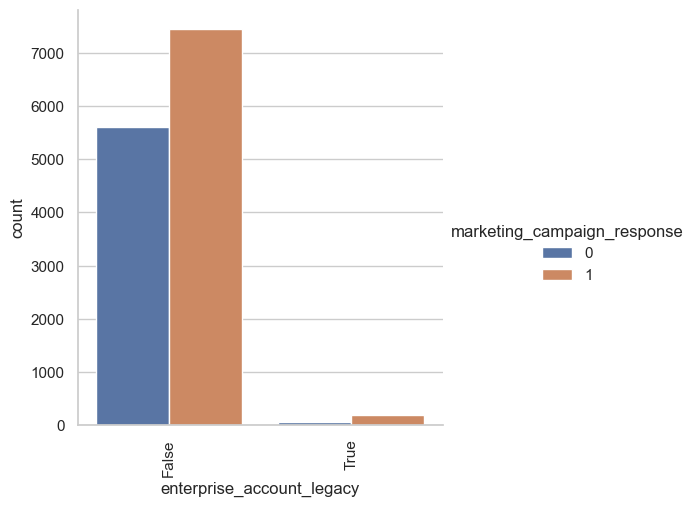

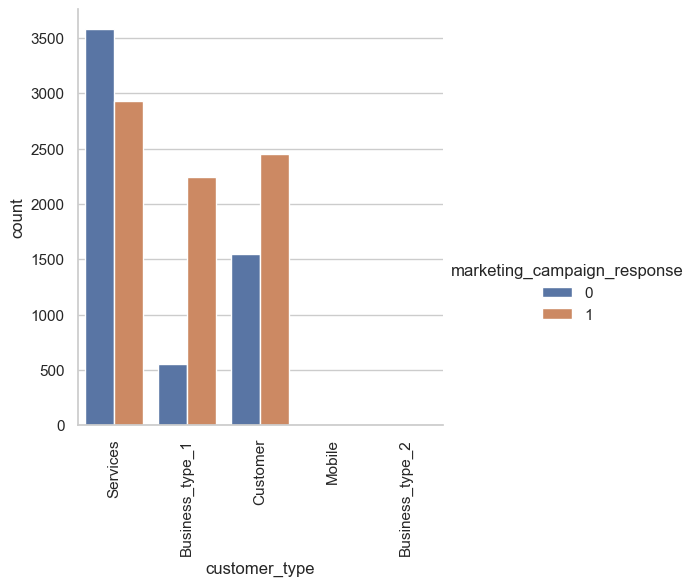

In [ ]:
# Variables of Potential Interest
bar('is_activated')
bar('has_cloud_storage')
bar('has_cloud_storage_only')
bar('tier_level')
bar('enterprise_account')
bar('enterprise_account_legacy')
bar('customer_type')

Graph observations:
  
- Customers with activated accounts respond more than non-activated accounts. Makes sense
- Customers with no previous cloud_storage with CloudCity had a greater proportion (8500/11000) of campaign responses compared to those who had it (2800/9000)
- Customers with premium subscriptions had higher rates of non-responsiveness compared to others. LITE, Basic, Premium Plus, Q, and DN all had a greater proportion in responses vs non-responses
- Customers with Enterprise accounts (76/20004) and Enterprise Accounts legacy do not tell us a story due to the very small amounts of data. Customers with no Enterprise accounts ~ 60/40 response vs non-response rate. CloudCity does not seem to distribute to large companies. The enterprise/legacy feature could possibly be removed.

### Violinplots 

In [56]:
def violin(feature):
    """
    Visualizes violin plots for numeric features
    """
    sns.violinplot(data = data, 
                x = "marketing_campaign_response",
                y = feature)
    plt.show()

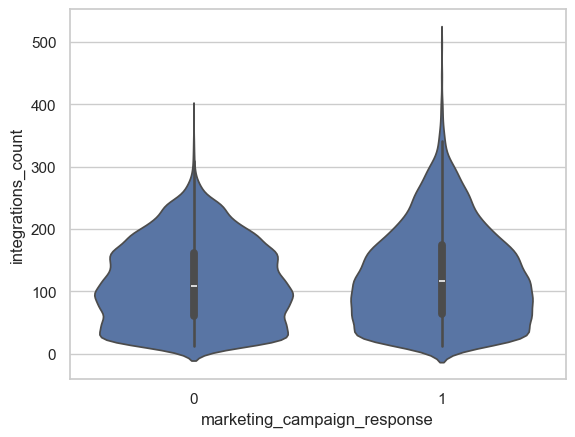

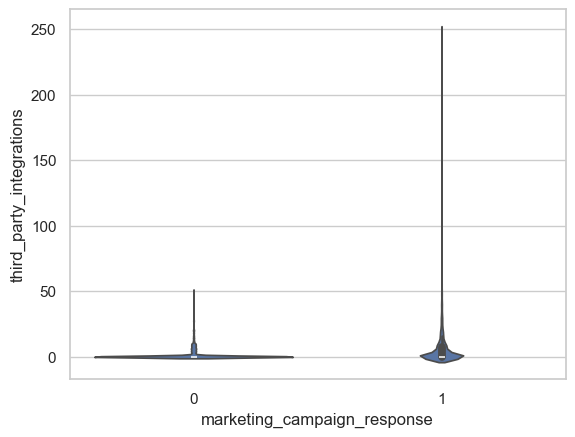

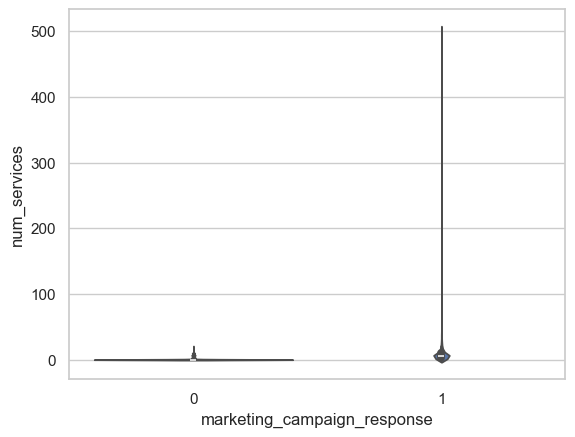

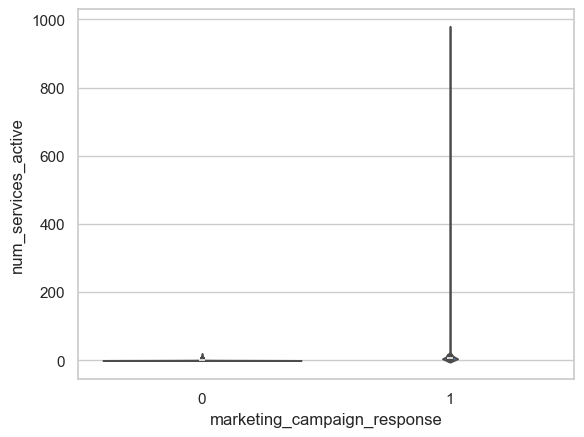

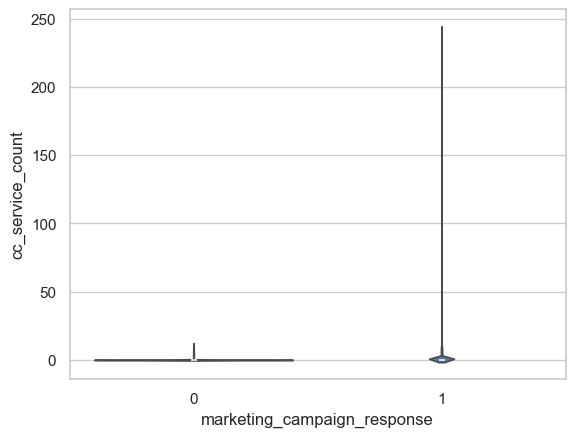

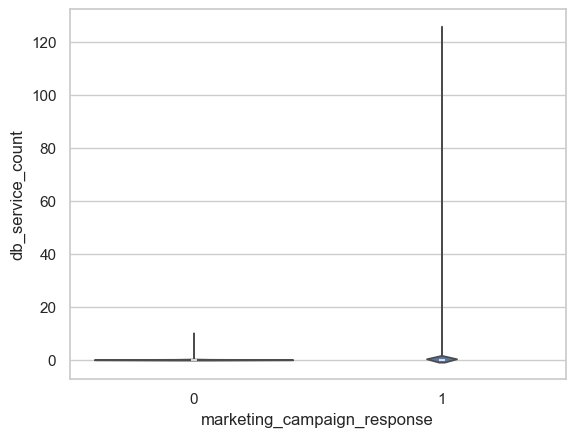

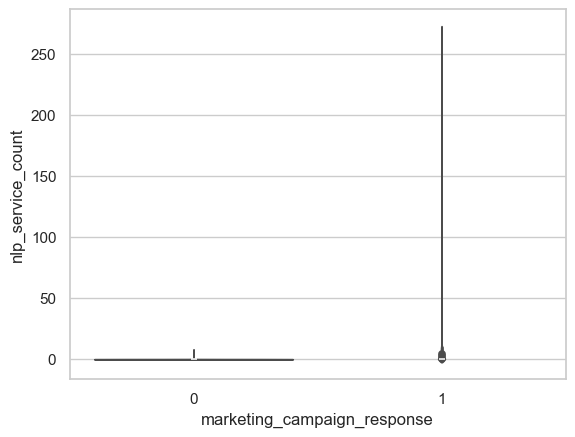

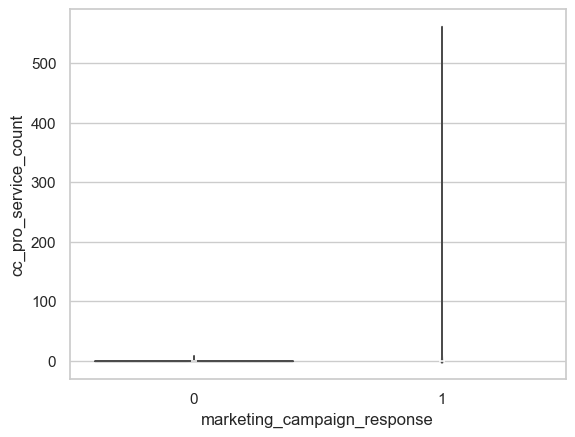

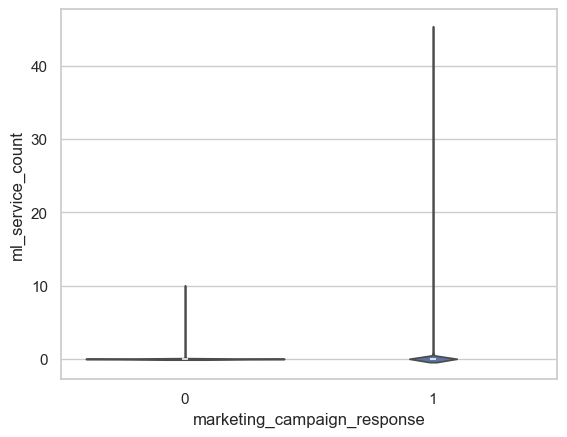

In [57]:
violin('integrations_count')
violin('third_party_integrations')
violin('num_services')
violin('num_services_active')
violin('cc_service_count')
violin('db_service_count')
violin('nlp_service_count')
violin('cc_pro_service_count')
violin('ml_service_count')

Observations:

- The features seem heavily imbalanced
- Plotting a boxplot for a variety of services (i.e. ML, DB, MLP) showed that most of the data is skewed to the right. In the summary statistics, at least 75% of each service are 0s, skewing the data heavily. However, it can be observed that customers who are subscribed to more services are more likely to respond to campaigns.

### Encoding

In [58]:
# Encode True and False to 1:0s
data.replace({False:0, True:1}, inplace=True)

/var/folders/w1/73jz_c6d4fz9dq3d41yh4h_80000gn/T/ipykernel_68493/3805050759.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({False:0, True:1}, inplace=True)


In [59]:
# Encode multi-class categorical variables (tier_level, customer_type)
le = LabelEncoder()
data[['tier_level', 'customer_type']] = data[['tier_level', 'customer_type']].apply(le.fit_transform)

### Correlation Matrix

Correlation measures the association between variables. The correlation matrix is a powerful and convenient visualization tool for monitoring relationships between variables. Features that are high in correlation to each other are more linearly dependent and may cause high variance in our model results. Therefore, if there are any features that are strongly correlated, we can remove one of them.

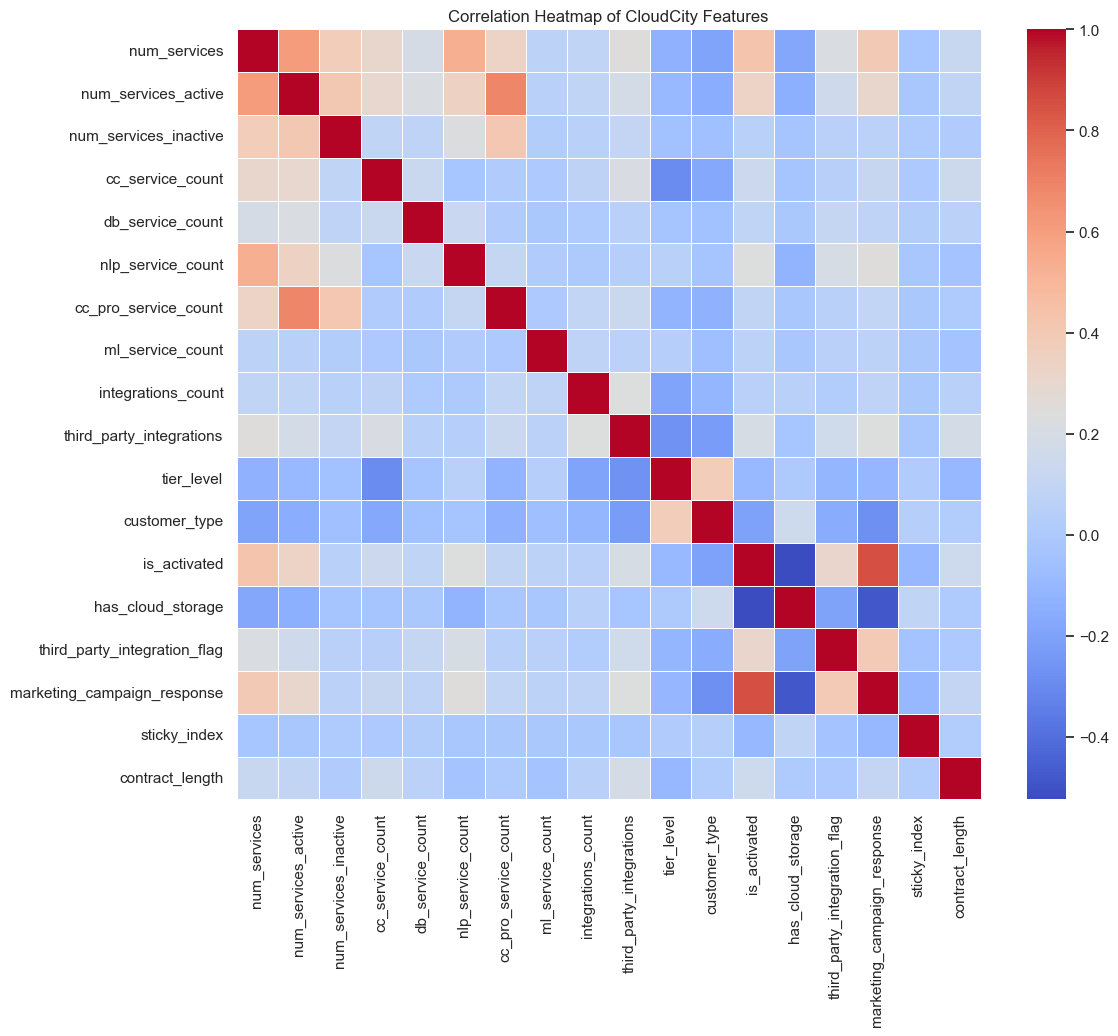

In [77]:
# Correlation Matrix
corr_matrix = data.drop(columns = ['address']).corr()

# Plotting heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, linecolor='white')
plt.title('Correlation Heatmap of CloudCity Features')
plt.show()

Having cloud storage and is_activated have strong relationships with cloud storage only relative to other variables. From this, we can possibly remove the cloud storage only feature.

In addition, I will also be dropping the Enterprise/Enterprise legacy features, based on my past exploration of the data.

In [61]:
data = data.drop(columns = ['has_cloud_storage_only', 
                            'enterprise_account',
                           'enterprise_account_legacy'])

## Machine Learning

In [62]:
X = data.drop(['marketing_campaign_response', 'address'], axis = 1) # Drop response
y = data['marketing_campaign_response'] # Campaign Response

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [64]:
x_train

,num_services,num_services_active,num_services_inactive,cc_service_count,db_service_count,nlp_service_count,cc_pro_service_count,ml_service_count,integrations_count,third_party_integrations,tier_level,customer_type,is_activated,has_cloud_storage,third_party_integration_flag,sticky_index,contract_length
19017,10,9,0,0,0,10,0,0,57.0,0.0,5,4,1,0,1,18.0,346.0
4850,10,12,0,0,0,1,0,0,210.0,9.0,5,4,1,0,1,26.0,1728.0
3231,4,8,0,0,0,1,0,0,126.0,0.0,5,4,1,0,1,20.0,156.0
7000,0,0,0,0,0,0,0,0,76.0,0.0,4,4,0,1,1,44.0,42.0
14862,9,2,0,0,0,6,0,0,60.0,0.0,2,2,1,0,2,53.0,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17769,0,0,0,0,0,0,0,0,115.0,0.0,4,2,0,1,1,23.0,38.0
21,0,0,0,0,0,0,0,0,20.0,0.0,4,2,0,1,1,301.0,328.0
12852,7,4,0,0,0,8,0,0,180.0,0.0,5,4,1,0,1,139.0,307.0
8784,6,7,0,0,0,10,0,0,18.0,0.0,5,4,1,0,2,41.0,40.0


Ensuring data is split properly in X and Y

In [65]:
x_train.shape

(10646, 17)

In [66]:
y_train.shape

(10646,)

## Model Selection

This is a supervised, classification Machine Learning problem. 

Random Forest and XGBoost are industry favorites for such issues. Through my courses and diving into prior research, I have learned that XGBoost and Random Forests perform decently well on binary classification problems. A major caveat, however, may lie in the difficulty in translating these metrics and results to senior leadership.

### Random Forest

In [67]:
# Define instance and fit
rf = RandomForestClassifier(random_state = 1)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [68]:
# Predictions
rf_pred = rf.predict(x_test)
print(len(rf_pred))

2662


In [69]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, rf_pred))

,0,1
0,1020,116
1,61,1465


In [70]:
# Classification Report
pd.DataFrame(classification_report(y_test, rf_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.943571,0.926629,0.933509,0.935100,0.933859
recall,0.897887,0.960026,0.933509,0.928957,0.933509
f1-score,0.920162,0.943032,0.933509,0.931597,0.933272
support,1136.000000,1526.000000,0.933509,2662.000000,2662.000000


### RF Best Features

I plotted a visualization to better understand which features are the best to split on during the Random Forest process. These features can give us a better understanding of which variables are best at partitioning campaign responses.

This could also be used for feature selection to reduce the complexity of the model. 

Text(0.5, 1.0, 'Visualizing RF Feature Importances for CloudCity')

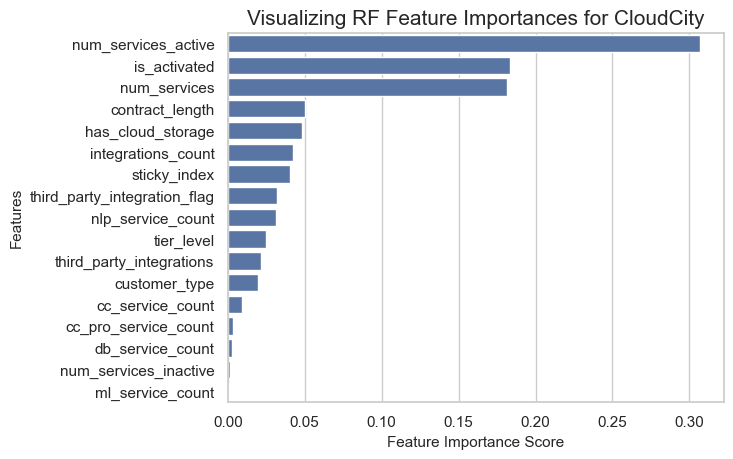

In [76]:
feature_imp = pd.Series(rf.feature_importances_,
                       index = x_train.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize = 11)
plt.ylabel('Features', fontsize = 11)
plt.title('Visualizing RF Feature Importances for CloudCity', fontsize = 15)

### XGBoost

In [72]:
# XGB Instance
xgb_classifier = xgb.XGBClassifier(n_estimators = 100, objective = "binary:logistic", tree_method = "exact")
# Fit model
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
xgb_pred = xgb_classifier.predict(x_test)
print(len(xgb_pred))

2662


In [74]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, xgb_pred))

,0,1
0,1038,98
1,63,1463


In [75]:
# Classification Report
pd.DataFrame(classification_report(y_test, xgb_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.942779,0.937220,0.939519,0.940000,0.939592
recall,0.913732,0.958716,0.939519,0.936224,0.939519
f1-score,0.928029,0.947846,0.939519,0.937937,0.939389
support,1136.000000,1526.000000,0.939519,2662.000000,2662.000000


## Evaluation 

From the performance metrics, I observed that Random Forest and XGBoost performed fairly evenly, with high metric values (accuracy, precision, recall). Because the classes are fairly balanced, accuracy could be a good measure of performance here. In the context of CloudCity's marketing campaigns, however, I believe having a higher precision rate (out of predicted positives engagement, how many were actually positive engagement) would lead in optimizing margins. In this case, XGBoost did a slightly better job (94% vs 93.4%).

## Conclusion

We have shown that with an implementation of machine learning algorithms, CloudCity's marketing team is able to confidently predict the complexity of whether a customer will respond to a marketing campaign. A few features that the team can take into consideration to infer a customer's responsiveness is through analyzing the customer's history of number of services ever used, number of services active, total contract length, and the engineeered sticky index. 

Through this process of trial and error, CloudCity has gained actionable insight that drives efficient decision making that would help improve revenue streams, drive down costs, and retain partnerships that lead to greater business fortune. 
